#### Add pre-installed package path & load packages:

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [1]:
# install coloc package
# if(!require("remotes"))
#    install.packages("remotes") # if necessary
# library(remotes)
# install_github("chr1swallace/coloc@main",build_vignettes=TRUE)

In [2]:
library("dplyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
library("TwoSampleMR")
library("readxl")
library("coloc")

TwoSampleMR version 0.5.11 
[>] New: Option to use non-European LD reference panels for clumping etc
[>] Some studies temporarily quarantined to verify effect allele
[>] See news(package = 'TwoSampleMR') and https://gwas.mrcieu.ac.uk for further details



You are running an old version of the TwoSampleMR package.
This version:   0.5.11
Latest version: 0.6.14
Please consider updating using remotes::install_github('MRCIEU/TwoSampleMR')

This is coloc version 5.2.3



#### Change working directory:

In [3]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD"

#### Test dataset:

In [4]:
data(coloc_test_data)
attach(coloc_test_data)
minimum_data=D1[c("beta","varbeta","snp","position","type","sdY")]
str(minimum_data)

List of 6
 $ beta    : num [1:500] 0.337 0.211 0.257 0.267 0.247 ...
 $ varbeta : num [1:500] 0.01634 0.00532 0.00748 0.01339 0.00664 ...
 $ snp     : chr [1:500] "s1" "s2" "s3" "s4" ...
 $ position: int [1:500] 1 2 3 4 5 6 7 8 9 10 ...
 $ type    : chr "quant"
 $ sdY     : num 1.1


In [5]:
check_dataset(minimum_data,warn.minp=1e-10)

NULL

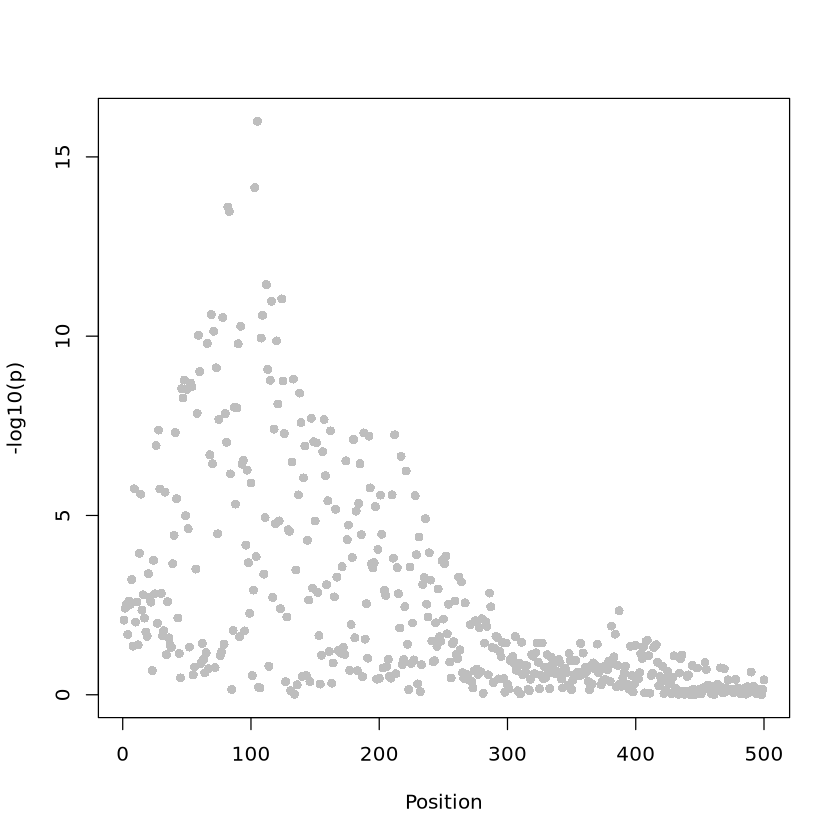

In [6]:
plot_dataset(minimum_data)

#### Prepare pQTLs:
- load all pQTLs per protein (regenie file)
- load per-protein lists of clumped lead variants (clumping using: p<5e-8, r2<0.1; see the 01_MR.ipynb notebook)
- set genomic region boundaries, based on recombination hotspot (see question here: https://chr1swallace.github.io/coloc/FAQ.html & https://bitbucket.org/nygcresearch/ldetect-data/src/master/)
- for lead pQTLs that fall in the same recombination hotspot block, choose the first one (it doesn't matter, since all pQTLs in the block are included)
- Include alleles, so you can align in the next step!
- IMPORTANT: include ONLY chromosomes 1-22 (there is no recombination hotspots regions information on chr 23)
- IMPORTANT: extract_protein_lead_variants_df() throws an error if there are no autosomal lead pQTLs for the protein 

In [36]:
## get recombination hotspots regions
gr <- 
    fread('pQTL_del_coloc/data/LDetect_map/ldetect-data/EUR/fourier_ls-all.bed') %>% 
    mutate(chr=gsub("chr", "", chr), start=start+1, stop=stop+1) # bed format is 0-based
head(gr, 3)

chr,start,stop
<chr>,<dbl>,<dbl>
1,10584,1892608
1,1892608,3582737
1,3582737,4380812


In [37]:
## make function to get per-protein lead variants & define nearby region.
## returns df with lead variants and nearby genomic regions

extract_protein_lead_variants_df <- function(protein_i) {
    ## load lead variants
    protein_i_lead_dir = paste0('pQTL_MR_analysis/data/per_protein/clumped/', protein_i, '.clumped')
    protein_i_lead <- 
        fread(protein_i_lead_dir, select = c('SNP', 'CHR','BP')) %>% arrange(CHR, BP) %>%
        ## IMPORTANT: include ONLY chromosomes 1-22 (there is no recombination hotspots regions information on chr 23)
        filter(CHR %in% c(1:22)) %>%
        # add +-2MB window
        mutate(WD_MIN = ifelse(BP - 1e6 >=0, BP - 1e6, 0),
               WD_MAX = BP + 1e6)
    ## return ERROR if there are no autosomal lead variants
    if (nrow(protein_i_lead)==0) {stop(paste0("No autosomal lead variants in protein ", protein_i))}
    ## add recomb.hotspot regions
    protein_i_lead$RH_MIN <- NA
    protein_i_lead$RH_MAX <- NA
    # loop through each lead pQTL
    for (j in 1:nrow(protein_i_lead)) {
        # extract lead pQTL's location
        chr_j   = protein_i_lead$CHR[[j]]
        bp_j    = protein_i_lead$BP[[j]]
        # extract genomic region that contains pQTL j
        start_j = gr %>% filter(chr == chr_j & start <= bp_j & stop > bp_j) %>% pull(start)
        stop_j  = gr %>% filter(chr == chr_j & start <= bp_j & stop > bp_j) %>% pull(stop)
        # add to lead pQTLs table
        protein_i_lead$RH_MIN[[j]] = start_j
        protein_i_lead$RH_MAX[[j]] = stop_j
    }
    ## pick one lead variant per block
    protein_i_lead <- protein_i_lead %>% group_by(RH_MIN) %>% filter(row_number()==1)
    # return df
    return(protein_i_lead)
}

In [38]:
##  make function to extract full pQTL sumstats for each genomic region 
## returns a df with all pQLTs within each lead variant's nearby region (use recombination hotspot bins)

extract_protein_full_pQTLs_df <- function(protein_i){
    ## extract lead variants (use function above)
    protein_i_lead <- extract_protein_lead_variants_df(protein_i)
    ## load full qQTL sumstats
    protein_i_all_dir = paste0('SBpQTL_project/SBMR/data/1.GWAS_on_protein/', protein_i, '/2.Step_2/Step2_', protein_i,'_NPX.regenie')
    protein_i_all <- 
        fread(protein_i_all_dir) %>% 
        select(ID, CHROM, ALLELE0, ALLELE1, GENPOS, BETA, SE, A1FREQ)
    ## get all pQTLs within each region (loop through each lead variant t
    for (t in 1:nrow(protein_i_lead)) {
        lead_t = protein_i_lead$SNP[[t]]
        chr_t = protein_i_lead$CHR[[t]]
        rh_min_t = protein_i_lead$RH_MIN[[t]]
        rh_max_t = protein_i_lead$RH_MAX[[t]]
        protein_i_t <-
        protein_i_all %>% 
            filter(CHROM == chr_t & GENPOS >= rh_min_t & GENPOS < rh_max_t) %>% 
            #filter(CHROM == protein_i_lead$CHR[[t]] & GENPOS >= protein_i_lead$WD_MIN[[t]] & GENPOS < protein_i_lead$WD_MAX[[t]])
            mutate(lead_variant = lead_t)
        # add all rows in one df
        if(lead_t == protein_i_lead$SNP[[1]]) {
            protein_i_all_blocks = protein_i_t
        }
        else {
            protein_i_all_blocks <- bind_rows(protein_i_all_blocks, protein_i_t)
        }
    }
    ## format for coloc usage
    protein_i_all_blocks_fmt <-
    protein_i_all_blocks %>% 
        mutate(varbeta = SE^2) %>%
        rename(snp=ID, position=GENPOS, allele0=ALLELE0, allele1=ALLELE1, beta=BETA, freq1=A1FREQ) %>%
        select(snp, position, allele0, allele1, freq1, beta, varbeta, lead_variant)
    return(protein_i_all_blocks_fmt)
}

##### example:

In [7]:
## example
protein_list <- list.files("SBpQTL_project/SBMR/data/1.GWAS_on_protein/")
protein_i = protein_list[3]
protein_i

protein_i_lead <- extract_protein_lead_variants_df(protein_i)
protein_i_all_blocks_fmt <- extract_protein_full_pQTLs_df(protein_i)

protein_i_lead

protein_i_all_blocks_fmt %>% dim
protein_i_all_blocks_fmt$lead_variant %>% unique
protein_i_all_blocks_fmt %>% head
protein_i_all_blocks_fmt %>% group_by(lead_variant) %>% summarise(n_pQTLs=n())

[1] "AARSD1"

SNP,CHR,BP,WD_MIN,WD_MAX,RH_MIN,RH_MAX
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
rs1354034,3,56849749,55849749,57849749,56433908,58157520
rs10774625,12,111910219,110910219,112910219,110336720,113263519
rs35166621,17,41113131,40113131,42113131,39899811,41772088


[1] 862   8

[1] "rs1354034"  "rs10774625" "rs35166621"

snp,position,allele0,allele1,freq1,beta,varbeta,lead_variant
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
rs2130881,56434215,G,A,0.0434450,-0.04292410,3.568623e-04,rs1354034
rs116320994,56434612,G,T,0.0211166,-0.04490160,7.235132e-04,rs1354034
rs11130520,56441119,T,G,0.3976130,-0.01004340,6.204965e-05,rs1354034
rs1491163,56453316,G,A,0.2153080,0.02006940,8.899753e-05,rs1354034
rs71309954,56462127,A,G,0.0989247,0.01681670,1.671642e-04,rs1354034
rs11719646,56467691,A,G,0.3605600,0.00645986,6.467585e-05,rs1354034


lead_variant,n_pQTLs
<chr>,<int>
rs10774625,320
rs1354034,281
rs35166621,261


#### Prepare delirium sumstats:
- use pos_hg19 to match with pQTLs
- extract only called SNPs
- Include alleles, so you can align in the next step!

In [4]:
## vector of called SNPs rsids
called <- fread('ukb_data/ukb44986/genomic_data/snpinfo/called/ukb_snp_qc.txt', select = 'rs_id') %>% pull(rs_id)
length(called)
head(called)

[1] 805426

[1] "rs28659788"  "rs116587930" "rs116720794" "rs3131972"   "rs12184325"  "rs3131962"

In [9]:
## load & format all delirium sumstats
del_all <- 
    fread("meta_analysis/metal_output/noAOU_noPROT/METAANALYSIS_DELIRIUM_noAOU_noPROT_QC.tbl") %>%
    mutate(varbeta=StdErr^2) %>%
    rename(snp=rsid, position=pos_hg19, beta=Effect, allele0=Allele2, allele1=Allele1, freq1=Freq1) %>%
    select(snp, position, allele0, allele1, beta, varbeta, freq1) %>%
    filter(snp %in% called)
del_all %>% dim
del_all %>% head

[1] 719156      7

snp,position,allele0,allele1,beta,varbeta,freq1
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
rs28659788,723307,G,C,-0.0591,0.00265225,0.9666
rs116587930,727841,G,A,-0.0072,0.00119025,0.0572
rs116720794,729632,C,T,0.0142,0.00254016,0.0361
rs3131972,752721,G,A,-0.0081,0.00038025,0.1852
rs12184325,754105,C,T,0.0119,0.00237169,0.0368
rs3131962,756604,G,A,-0.0138,0.00041209,0.1653


In [6]:
## load & format all delirium sumstats - dementia-free GWAS !!in hg38 positions!!
del_all_nodem <- 
    fread('ukb.delirium.gwas/from_rap/nodem/nodem_hg38_final.txt') %>%
    mutate(varbeta=SE^2) %>%
    rename(SNP=ID, position=GENPOS, beta=BETA, allele0=ALLELE0, allele1=ALLELE1, freq1=A1FREQ, chr=CHROM) %>%
    select(SNP, position, allele0, allele1, beta, varbeta, freq1, chr) %>%
    filter(SNP %in% called)
del_all_nodem %>% dim
del_all_nodem %>% head

[1] 720691      8

SNP,position,allele0,allele1,beta,varbeta,freq1,chr
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
rs28659788,787927,C,G,0.07009680,0.0043649674,0.0357017,1
rs116587930,792461,G,A,-0.01550110,0.0027862140,0.0524763,1
rs116720794,794252,C,T,0.04022060,0.0035563213,0.0358326,1
rs3131972,817341,A,G,0.00259859,0.0008706158,0.8408470,1
rs12184325,818725,C,T,0.03576660,0.0033208942,0.0365069,1
rs3131962,821224,A,G,0.01955250,0.0009870405,0.8702440,1


In [18]:
## liftover delirium nodem sumstats: hg38 -> hg19

LIFTOVER  = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/software/liftOver"
CHAINFILE = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/resources/liftOver_files/hg38ToHg19.over.chain.gz"
OUTDIR    = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/pQTL_del_coloc/data/"
temp_in_file = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/pQTL_del_coloc/data/temp_liftover_in.BED"

# make BED input
temp_in <- del_all_nodem %>% 
    mutate(CHR = paste0("chr", chr), POS0 = position-1) %>% 
    select(CHR, POS0, position, SNP) %>% 
    arrange(SNP) %>% filter(!duplicated(SNP)) # select only unique SNPs
fwrite(temp_in, temp_in_file, sep = " ", quote = F, row.names = F, col.names = F, scipen=50)
# run liftOver
system(paste0(
    LIFTOVER,
    " -bedPlus=3 ", 
    temp_in_file, " ",
    CHAINFILE, " ",
    OUTDIR, "temp_liftover_out.BED ",
    OUTDIR, "temp_liftover_unmapped.BED "),
       intern = T
      )
# load hg19 positions (excludes unmapped)
temp_hg19 <- fread(paste0(OUTDIR, "temp_liftover_out.BED"))

del_all_nodem_hg19 <-
    left_join(x=del_all_nodem, y=temp_hg19[,c("V1","V3","V4")], by=c("SNP"="V4")) %>% 
    rename(position_hg19 = V3,
          snp = SNP) %>%
    mutate(chr38 = gsub("chr", "", V1)) %>%
    filter(chr==chr38) %>%
    select(-c(V1, chr38))
# remove temp data
system("rm pQTL_del_coloc/data/temp_*", intern=T)

character(0)

character(0)

In [23]:
## reformat hg19 sumstats
del_all_nodem_f <-
    del_all_nodem_hg19 %>%
    mutate(position=position_hg19) %>%
    select(snp, position, allele0, allele1, beta, varbeta, freq1)

##### Align with protein sumstats

In [39]:
## make function that returns df with delirium beta's aligned to protein_i alleles

align_delirium_betas <- function(del_all, protein_i_all_blocks_fmt) {
    
    del_fmt_i <- 
    protein_i_all_blocks_fmt %>%
    # merge protein and delirium dfs
    inner_join(x=., y=del_all, by = c('snp','position'), suffix = c('_prot','_del')) %>%
    # check whether alleles need to be reversed (0: same alleles; 1: reverse alleles; other diffent alleles)
    mutate( is_reversed = case_when(allele0_prot == allele0_del  & allele1_prot == allele1_del ~ 0, # alleles are the same
                                    allele0_prot == allele1_del  & allele1_prot == allele0_del ~ 1, # alleles are reverse
                                    TRUE ~ NA # alleles are not the same (discard)
                                   )
          ) %>%
    # change delirium sumstats for reversed alleles
    mutate( beta_del_aligned  = ifelse(is_reversed==0, beta_del, -1*beta_del),  # change sign of beta
            freq1_del_aligned = ifelse(is_reversed==0, freq1_del, 1-freq1_del), # 1-freq
            allele0_del_aligned = ifelse(is_reversed==0, allele0_del, allele1_del),
            allele1_del_aligned = ifelse(is_reversed==0, allele1_del, allele0_del)
          ) %>%
    # make freq-difference column
    mutate(freq_diff = freq1_del_aligned - freq1_prot) %>%
    # filter out missing values
    filter(!is.na(beta_del_aligned)) %>%
    # filter out duplicated snps
    filter(!duplicated(snp)) %>%
    # extract coloc-required delirium columns
    rename(beta=beta_del_aligned, 
           varbeta=varbeta_del, 
           allele0=allele0_del_aligned,
           allele1=allele1_del_aligned,
           freq1=freq1_del_aligned
          ) %>%
    select(snp, position, allele0, allele1, beta, varbeta, freq1, freq_diff)
    return(del_fmt_i)
}

#### Run coloc

##### make input lists:

In [40]:
## make list objects for genomic region around lead variant t(=0,1,2..)
## returns a list of lists: 1 list for delirium sumstats and 1 list for protein sumstats, ready for coloc usage

make_lists_i_t <- function(del_fmt_i, protein_i_all_blocks_fmt, lead_variant_t) {
    # get all lead variants
    lead_variants_i <- unique(protein_i_all_blocks_fmt$lead_variant)
    lead_variants_i[lead_variant_t]
    # extract list of pQTLs around lead variant t
    protein_i_t_list <-
    protein_i_all_blocks_fmt %>%
        filter(lead_variant==lead_variants_i[lead_variant_t]) %>%
        as.list()
    protein_i_t_list[['lead_variant']] <- protein_i_t_list[['lead_variant']][1]
    protein_i_t_list[['type']] <- 'quant'
    protein_i_t_list[['sdY']]  <- 1
    protein_i_t_list[['phenotype']] <- protein_i
    # extract list of delirium sumstats around lead variant t
    del_fmt_i_t_list <-
        del_fmt_i %>%
        filter(snp %in% protein_i_t_list[['snp']]) %>%
        as.list()
    del_fmt_i_t_list[['lead_variant']] <- protein_i_t_list[['lead_variant']][1]
    del_fmt_i_t_list[['type']] <- 'cc'
    del_fmt_i_t_list[['phenotype']] <- 'delirium'
    # make a list including the two lists: 1-> protein; 2-> delirium
    both_i_t <- list(protein_i_t_list, del_fmt_i_t_list)
    return(both_i_t)
}


##### (Approximate) Bayes Factor colocalisation analyses:

see: https://chr1swallace.github.io/coloc/articles/a03_enumeration.html

The idea behind the ABF analysis is that the association of each trait with SNPs in a region may be summarised by a vector of 0s and at most a single 1, with the 1 indicating the causal SNP (so, assuming a single causal SNP for each trait). The posterior probability of each possible configuration can be calculated and so, crucially, can the posterior probabilities that the traits share their configurations. This allows us to estimate the support for the following cases:

- $H0$: neither trait has a genetic association in the region
- $H1$: only trait 1 has a genetic association in the region
- $H2$: only trait 2 has a genetic association in the region
- $H3$: both traits are associated, but with different causal variants
- $H4$: both traits are associated and share a single causal variant


In [41]:
## wrapper function that runs coloc.abf for one protein + delirium
## returns a df with results for each lead variant region

run_coloc_abf <- function(protein_i, del_all){
    ## extract lead pQTLs df (to extract the genomic region limits)
    protein_i_lead <- extract_protein_lead_variants_df(protein_i)
    ## extract pQLTs within each lead variant's region
    protein_i_all_blocks_fmt <- extract_protein_full_pQTLs_df(protein_i)
    ## extract aligned delirium sumstats
    del_fmt_i <- align_delirium_betas(del_all, protein_i_all_blocks_fmt)
    ## run coloc for each genomic region for protein i
    lead_variants_i <- unique(protein_i_all_blocks_fmt$lead_variant)
    for (t in 1:length(lead_variants_i)) {
#        cat(paste0('lead variant: ', lead_variants_i[t], '\n'))
        ## make lists input
        both_i_t <- make_lists_i_t(del_fmt_i, protein_i_all_blocks_fmt,t)
        ## protein i
        protein_i_t_list <- both_i_t[[1]]
#        print(check_dataset(protein_i_t_list, warn.minp=1e-5))
        ## delirium
        del_fmt_i_t_list <- both_i_t[[2]]
#        print(suppressWarnings(check_dataset(del_fmt_i_t_list)))
        ## run coloc.abf
        abf_i_t <- coloc.abf(dataset1 = protein_i_t_list, dataset2 = del_fmt_i_t_list) %>% suppressWarnings
        ## make results table
        if(lead_variants_i[t] == lead_variants_i[1]) {
            abf_i_all_regions = data.frame(t(abf_i_t$summary))
            abf_i_all_regions$lead_variant <- lead_variants_i[t]
            abf_i_all_regions$chrom <- protein_i_lead$CHR[[t]]
            abf_i_all_regions$bp_lead_hg19 <- protein_i_lead$BP[[t]]
            abf_i_all_regions$bp_min_hg19  <- protein_i_lead$RH_MIN[[t]]
            abf_i_all_regions$bp_max_hg19  <- protein_i_lead$RH_MAX[[t]]
        }
        else {
            abf_i_all_regions <- bind_rows(abf_i_all_regions, data.frame(t(abf_i_t$summary)))
            abf_i_all_regions$lead_variant[[t]] <- lead_variants_i[t]
            abf_i_all_regions$chrom[[t]] <- protein_i_lead$CHR[[t]]
            abf_i_all_regions$bp_lead_hg19[[t]] <- protein_i_lead$BP[[t]]
            abf_i_all_regions$bp_min_hg19[[t]]  <- protein_i_lead$RH_MIN[[t]]
            abf_i_all_regions$bp_max_hg19[[t]]  <- protein_i_lead$RH_MAX[[t]]
        }
    }
    ## add protein name to results df
    abf_i_all_regions$protein <- protein_i
    ## rearrange columns
    cols_ordered <- c('protein', 'lead_variant', 'chrom', 'bp_lead_hg19', 'bp_min_hg19', 'bp_max_hg19', 'nsnps', 'PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf')
    abf_i_all_regions <- abf_i_all_regions %>% select(all_of(cols_ordered))
    ## return results df
    return(abf_i_all_regions)
} 

In [44]:
## run coloc for all proteins 

## assign delirium sumstats
del_all = del_all_nodem_f

## get only the proteins with >=1 lead variant
protein_list <- list.files("SBpQTL_project/SBMR/data/1.GWAS_on_protein/")
clumped_list = list.files('pQTL_MR_analysis/data/per_protein/clumped/', pattern='\\.') %>% gsub('\\.clumped', "", .)
protein_list_clumpedonly = intersect(protein_list, clumped_list)

## progress bar
pb = txtProgressBar(min = 0, max = length(protein_list_clumpedonly), initial = 0) 

## loop through all proteins in protein_list_clumpedonly
for (i in 1:length(protein_list_clumpedonly)) {
#for (i in 250:252) {
    protein_i = protein_list_clumpedonly[i]
    ## run colol.abf for protein_i + delirium (invisible+capture.output are for hiding the coloc.abf output)
    invisible(
        capture.output(
            abf_i_all_regions <- try(run_coloc_abf(protein_i, del_all), silent=T)
        )
    )
    ## skip protein if there are no autosomal lead variants
    if (class(abf_i_all_regions)=='try-error') next
    ## make output df for all proteins
    if (protein_i ==  protein_list_clumpedonly[1]) {
        abf_all_proteins <- abf_i_all_regions
    }
    else{
        abf_all_proteins <- bind_rows(abf_all_proteins, abf_i_all_regions)
    }
    ## print progress
    setTxtProgressBar(pb,i)
    cat(paste0("\rRun coloc.abf for ", i, " out of ",  length(protein_list_clumpedonly), " proteins (", round((i / length(protein_list_clumpedonly)*100),2), "%) ..."))
}


Run coloc.abf for 2464 out of 2464 proteins (100%) .....=

In [47]:
dim(abf_all_proteins)
abf_all_proteins %>% arrange(desc(PP.H4.abf)) %>% filter(PP.H4.abf > 0.6) %>% head

[1] 17634    12

,protein,lead_variant,chrom,bp_lead_hg19,bp_min_hg19,bp_max_hg19,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PLA2G7,rs13344893,19,45138246,44744109,46102698,405,1.312796e-137,4.094827e-16,3.205986e-125,1.980758e-10,1.0000000
2,HMOX2,rs4420638,19,45422946,44744109,46102698,405,9.440198e-24,4.094953e-16,2.305396e-11,3.088151e-08,1.0000000
3,BRK1,rs6859,19,45382034,44744109,46102698,405,1.199549e-35,4.095584e-16,2.929426e-23,1.853005e-07,0.9999998
4,APOA1,rs62117160,19,45232161,44744109,46102698,405,8.939228e-24,4.110327e-16,2.183054e-11,3.789132e-06,0.9999962
5,IL32,rs4420638,19,45422946,44744109,46102698,405,6.012354e-20,4.140800e-16,1.468281e-07,1.123868e-05,0.9999886
6,RP2,rs41289512,19,45351516,44744109,46102698,405,6.397218e-35,4.185655e-16,1.562268e-22,2.220347e-05,0.9999778


In [65]:
setdiff(protein_list_clumpedonly, unique(abf_all_proteins$protein))

[1] "C1GALT1C1"      "SPACA5_SPACA5B"

##### save results:

In [46]:
# fwrite(abf_all_proteins, 'pQTL_del_coloc/output/coloc.abf_prot_delirium.txt', sep=" ")
fwrite(abf_all_proteins, 'pQTL_del_coloc/output/coloc.abf_prot_delirium_nodem.txt', sep=" ")

##### example:

List of 11
 $ snp         : chr [1:299] "rs113212335" "rs16843273" "rs6694349" "rs7512203" ...
 $ position    : int [1:299] 234601869 234603205 234606799 234607419 234607584 234608326 234609264 234613050 234613331 234620980 ...
 $ allele0     : chr [1:299] "G" "C" "C" "T" ...
 $ allele1     : chr [1:299] "A" "T" "T" "C" ...
 $ freq1       : num [1:299] 0.0306 0.0352 0.0876 0.0508 0.3146 ...
 $ beta        : num [1:299] 0.01649 -0.01175 0.00853 0.04434 -0.00667 ...
 $ varbeta     : num [1:299] 0.00048 0.000423 0.000179 0.000294 0.000065 ...
 $ lead_variant: chr "rs526936"
 $ type        : chr "quant"
 $ sdY         : num 1
 $ phenotype   : chr "A1BG"


NULL

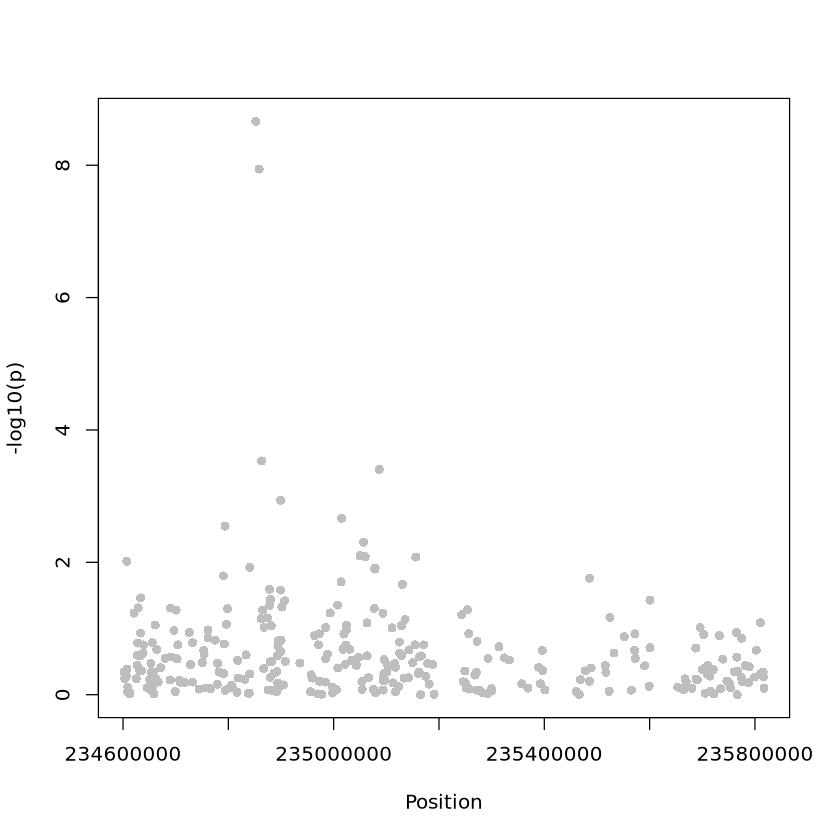

In [82]:
## protein
protein_i_t_list <- both_i_t[[1]]
# check
str(protein_i_t_list)
check_dataset(protein_i_t_list, warn.minp=1e-5)
plot_dataset(protein_i_t_list)


List of 11
 $ snp         : chr [1:298] "rs113212335" "rs16843273" "rs6694349" "rs7512203" ...
 $ position    : int [1:298] 234601869 234603205 234606799 234607419 234607584 234608326 234609264 234613050 234613331 234620980 ...
 $ allele0     : chr [1:298] "G" "C" "C" "T" ...
 $ allele1     : chr [1:298] "A" "T" "T" "C" ...
 $ beta        : num [1:298] -0.0468 0.0048 -0.0134 -0.0164 0.029 -0.0192 -0.0158 -0.0076 -0.0245 -0.0045 ...
 $ varbeta     : num [1:298] 0.002285 0.001011 0.000635 0.001354 0.00024 ...
 $ freq1       : num [1:298] 0.0267 0.0698 0.0936 0.0478 0.3182 ...
 $ freq_diff   : num [1:298] -0.00391 0.0346 0.00599 -0.00304 0.00358 ...
 $ lead_variant: chr "rs526936"
 $ type        : chr "cc"
 $ phenotype   : chr "delirium"


Warning message in check_dataset(del_fmt_i_t_list):
“minimum p value is: 0.0017924
If this is what you expected, this is not a problem.
If this is not as small as you expected, please check you supplied var(beta) and not sd(beta) for the varbeta argument. If that's not the explanation, please check the 02_data vignette.”


NULL

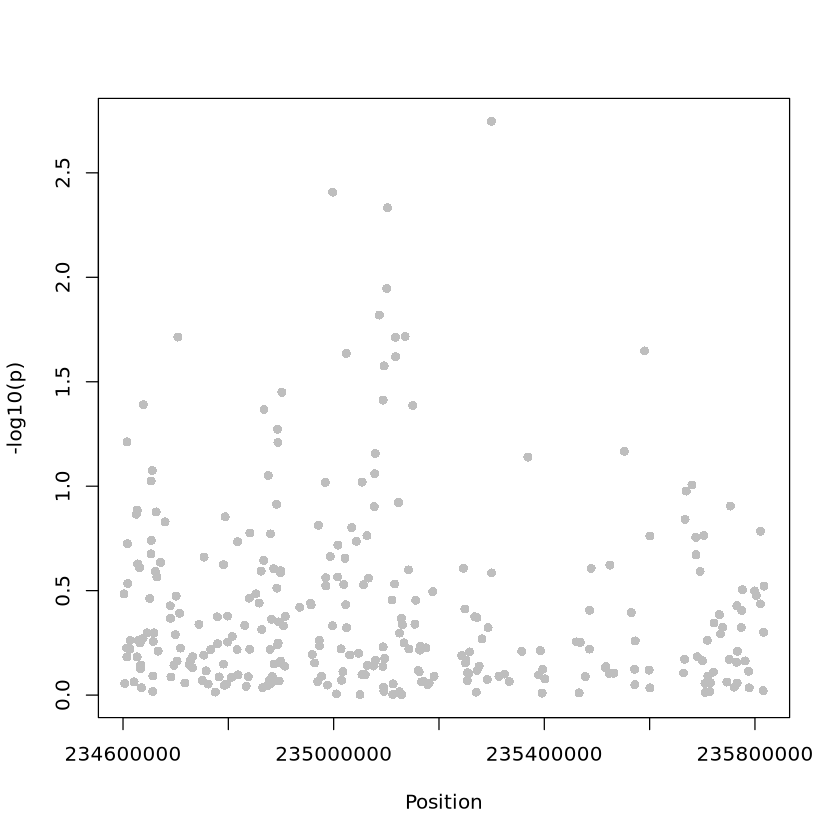

In [84]:
## delirium
del_fmt_i_t_list <- both_i_t[[2]]
# check
str(del_fmt_i_t_list)
check_dataset(del_fmt_i_t_list)
plot_dataset(del_fmt_i_t_list)

In [94]:
abf_i_t <- coloc.abf(dataset1 = protein_i_t_list, dataset2 = del_fmt_i_t_list) %>% suppressWarnings
#print(abf_i_t)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 2.82e-03  9.74e-01  3.44e-05  1.19e-02  1.12e-02 
[1] "PP abf for shared variant: 1.12%"


In [97]:
abf_i_t$summary

nsnps    PP.H0.abf    PP.H1.abf    PP.H2.abf    PP.H3.abf    PP.H4.abf 
2.980000e+02 2.815672e-03 9.740175e-01 3.443490e-05 1.190074e-02 1.123166e-02

In [87]:
1.12e-02 

[1] 0.0112

### Compare non-stratified / dementia-free

In [50]:
full <- fread('pQTL_del_coloc/output/coloc.abf_prot_delirium.txt')

In [60]:
nodem_top <- abf_all_proteins %>% arrange(desc(PP.H4.abf)) %>% filter(PP.H4.abf > 0.9) %>% pull(protein)

In [63]:
abf_all_proteins %>% arrange(desc(PP.H4.abf)) %>% filter(PP.H4.abf > 0.9)

protein,lead_variant,chrom,bp_lead_hg19,bp_min_hg19,bp_max_hg19,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PLA2G7,rs13344893,19,45138246,44744109,46102698,405,1.312796e-137,4.094827e-16,3.205986e-125,1.980758e-10,1.0000000
HMOX2,rs4420638,19,45422946,44744109,46102698,405,9.440198e-24,4.094953e-16,2.305396e-11,3.088151e-08,1.0000000
BRK1,rs6859,19,45382034,44744109,46102698,405,1.199549e-35,4.095584e-16,2.929426e-23,1.853005e-07,0.9999998
APOA1,rs62117160,19,45232161,44744109,46102698,405,8.939228e-24,4.110327e-16,2.183054e-11,3.789132e-06,0.9999962
IL32,rs4420638,19,45422946,44744109,46102698,405,6.012354e-20,4.140800e-16,1.468281e-07,1.123868e-05,0.9999886
RP2,rs41289512,19,45351516,44744109,46102698,405,6.397218e-35,4.185655e-16,1.562268e-22,2.220347e-05,0.9999778
SNAP25,rs714948,19,45165912,44744109,46102698,405,0.000000e+00,4.260346e-16,0.000000e+00,4.046219e-05,0.9999595
PALM,rs41289512,19,45351516,44744109,46102698,405,8.000479e-57,4.399523e-16,1.953802e-44,7.448472e-05,0.9999255
CEND1,rs4420638,19,45422946,44744109,46102698,405,9.950999e-22,4.462556e-16,2.430139e-09,8.989342e-05,0.9999101


In [61]:
full_top <- full %>% arrange(desc(PP.H4.abf)) %>% filter(PP.H4.abf > 0.9) %>% pull(protein)

In [64]:
setdiff(nodem_top, full_top)
setdiff(full_top, nodem_top)


[1] "NUDT16" "GALNT7"

[1] "CSNK2A1" "APOE"    "MENT"    "APOF"    "BPIFB2"  "ERN1"    "SMPDL3A" "ARSA"    "CREG1"   "NAAA"    "MAN2B2"  "APOA2"   "SMPD1"   "CTSZ"    "IDUA"    "CPQ"     "CES1"    "VWA1"    "CTSF"   
[20] "CTSO"    "CD99L2"  "COQ7"    "GLB1"